# Modelagem Preditiva de Sucesso de Filmes

# 1. Definição do Problema e Setup

Este projeto tem como finalidade aplicar técnicas de Aprendizado de Máquina para construir um modelo capaz de prever o sucesso financeiro de filmes a partir de suas características. A variável alvo utilizada é o profit (lucro), calculado como a diferença entre a receita e o orçamento. A previsão desse valor possibilita estimar o potencial financeiro de novas produções, auxiliando estúdios e investidores na tomada de decisões estratégicas.

O problema é formulado como uma tarefa de regressão, pois envolve a previsão de um valor numérico contínuo. Para isso, são testados diferentes modelos de aprendizado de máquina, comparando seu desempenho na previsão do lucro.

## 1.1. Sobre o Dataset Utilizado

O modelo é treinado com dados provenientes do MovieLens + TMDB Metadata Dataset, um conjunto de informações amplamente utilizado em projetos de ciência de dados. O arquivo principal (movies_metadata.csv) contém metadados de aproximadamente 45 mil filmes lançados até julho de 2017, incluindo informações de orçamento, receita, elenco, equipe técnica, idiomas, palavras-chave, estúdios, países de produção, data de lançamento, popularidade e avaliações do TMDB.

Além disso, o dataset completo inclui 26 milhões de avaliações realizadas por 270 mil usuários, embora este projeto utilize apenas o arquivo de metadados dos filmes. Parte das colunas está em formato de JSON como texto (ex.: keywords, cast, crew), enquanto outras apresentam variabilidade, inconsistências e valores ausentes, exigindo uma etapa cuidadosa de limpeza para uso em modelos preditivos. Esses dados foram originalmente coletados pela TMDB e pelo portal GroupLens.

## 1.2. Descrição das Técnicas de Aprendizado de Máquina

Para resolver o problema de regressão, são aplicados três algoritmos de complexidade crescente, além de um modelo baseline para referência. Cada um deles aprende a partir dos dados históricos a relação entre as características do filme (como orçamento, popularidade, países e palavras-chave) e o lucro obtido.

## 1.3. Dummy Regressor (Baseline)

O Dummy Regressor funciona como linha de base para comparação. Ele não utiliza as features; apenas retorna uma estimativa simples — neste caso, o lucro médio dos filmes do conjunto de treino. O objetivo é definir um patamar mínimo: qualquer modelo de Machine Learning só é útil se superar esse desempenho.

## 1.4. Regressão Linear

A Regressão Linear busca ajustar uma relação linear entre as features e o lucro. O modelo calcula um conjunto de coeficientes que representam o peso de cada variável. A previsão final é uma combinação linear dessas variáveis. O processo de treinamento consiste em encontrar os coeficientes que minimizam o erro entre as previsões e os valores reais de lucro.

## 1.5. Random Forest Regressor

O Random Forest utiliza diversas árvores de decisão construídas sobre subconjuntos aleatórios dos dados e das features. Cada árvore contribui com uma estimativa, e a média dessas previsões forma o resultado final. Essa técnica reduz o risco de overfitting típico de árvores individuais, proporcionando um modelo mais estável e robusto.

## 1.6. XGBoost Regressor

O XGBoost é um método de ensemble avançado, baseado em Gradient Boosting, e não foi abordado em sala de aula. Diferentemente do Random Forest, ele constrói árvores de forma sequencial, onde cada nova árvore é treinada para corrigir os erros das anteriores. Esse processo torna o modelo altamente eficiente e frequentemente superior em desempenho, sendo um dos mais utilizados em competições de ciência de dados.

## 1.7. Setup e Importação de Bibliotecas

O projeto utiliza bibliotecas para manipulação e análise dos dados (como pandas e numpy), visualização (matplotlib e seaborn), e modelagem (scikit-learn e xgboost). Esse conjunto de ferramentas permite realizar toda a limpeza, transformação e modelagem de forma organizada e reprodutível.

In [7]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb



No projeto, utilizamos pandas e numpy para carregar, manipular e organizar os dados, realizando operações numéricas essenciais. As bibliotecas matplotlib e seaborn auxiliam na criação de gráficos e análises visuais durante a etapa de exploração dos dados, enquanto ast ajuda a converter strings que representam listas ou dicionários em estruturas reais de Python. Suprimimos avisos desnecessários com warnings para manter o notebook limpo. Para o processo de modelagem, usamos ferramentas do scikit-learn: dividimos o conjunto em treino e teste com train_test_split, aplicamos validação cruzada com KFold e buscamos melhores configurações de modelos com GridSearchCV. O pré-processamento é estruturado com StandardScaler para padronizar variáveis numéricas, MultiLabelBinarizer para transformar listas de categorias, além de Pipeline e ColumnTransformer para organizar e aplicar todas as transformações de forma automática e consistente. A avaliação dos modelos é feita com métricas como MSE, MAE e R². Para comparação, usamos um DummyRegressor como baseline e, em seguida, modelos de maior complexidade, como LinearRegression, RandomForestRegressor e o mais avançado XGBoost, capaz de capturar relações não lineares de forma mais eficiente.


In [8]:
# Download dos Dados
!gdown 1txPbx3N6ACzhmAoAetuNus77MF87iTk6



Downloading...
From: https://drive.google.com/uc?id=1txPbx3N6ACzhmAoAetuNus77MF87iTk6
To: /content/movies_metadata.csv
100% 34.4M/34.4M [00:00<00:00, 113MB/s]


# 2. Preparação e Limpeza dos Dados para ML

Com as bibliotecas carregadas, inicia-se a preparação do dataset, para garantir que o modelo de aprendizado de máquina receba informações consistentes. O processo organiza as variáveis, converte colunas incorretas para formatos adequados, remove registros inválidos e prepara a variável alvo `profit`, que será utilizada como referência para as previsões.

### 2.1. Carregamento e Criação da Variável Alvo

O dataset é carregado novamente e as principais colunas numéricas (orçamento, receita, duração, popularidade e métricas de votação) são convertidas para valores numéricos, tratando erros e ausências para evitar falhas posteriores. Em seguida, o conjunto é filtrado para manter apenas filmes que possuam valores reais de orçamento e receita, já que entradas zeradas não contribuem para uma análise confiável.

Com os dados consistentes, cria-se a variável alvo `profit`, definida como a diferença entre `revenue` e `budget`. Esse valor representa o lucro do filme e passa a ser aquilo que o modelo tentará prever ao longo das etapas seguintes.


In [9]:
# --- Célula 5: Limpeza e Criação do Alvo (Código) ---

# Carregando o dataset
df = pd.read_csv('movies_metadata.csv', low_memory=False)

# 1. Limpeza e Conversão
# Converte colunas numéricas essenciais, tratando erros e NaNs como 0.
df['budget'] = pd.to_numeric(df['budget'], errors='coerce').fillna(0)
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce').fillna(0)
df['runtime'] = pd.to_numeric(df['runtime'], errors='coerce').fillna(0)
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce').fillna(0)
df['vote_average'] = pd.to_numeric(df['vote_average'], errors='coerce').fillna(0)
df['vote_count'] = pd.to_numeric(df['vote_count'], errors='coerce').fillna(0)

# 2. Filtragem: Consideramos apenas filmes com orçamento e receita conhecidos
df_limpo = df[(df['budget'] > 1000) & (df['revenue'] > 1000)].copy()

# 3. Cria a Variável Alvonana
df_limpo['profit'] = df_limpo['revenue'] - df_limpo['budget']


### 2.2. Recriação das Listas de Features (JSON)
Para o ML, as colunas `genres`, `production_countries` e `production_companies` devem ser transformadas em listas de strings.



In [10]:
# Conversão de JSON
# 1. Parsing para Gêneros ('genres')
df_limpo['genre_list'] = df_limpo['genres'].apply(
    lambda x: [d['name'] for d in ast.literal_eval(x)]
    if isinstance(x, str)
    else []
)

# 2. Parsing para Países ('production_countries')
df_limpo['country_list'] = df_limpo['production_countries'].apply(
    lambda x: [d['name'] for d in ast.literal_eval(x)]
    if isinstance(x, str)
    else []
)

# 3. Parsing para Empresas ('production_companies')
df_limpo['company_list'] = df_limpo['production_companies'].apply(
    lambda x: [d['name'] for d in ast.literal_eval(x)]
    if isinstance(x, str)
    else []
)


### 2.3. Seleção de Features e Codificação para ML (Melhoria 2)

Nesta etapa, realiza-se uma filtragem das categorias de gêneros e países com base na sua frequência no dataset. Como essas variáveis possuem grande diversidade e podem gerar centenas de colunas após a binarização, utiliza-se apenas as categorias mais recorrentes — especificamente, os 20 gêneros e os 10 países mais frequentes. Esse critério reduz a dimensionalidade, evita a criação de colunas pouco representativas e diminui o risco de overfitting. Após essa seleção, aplica-se o `MultiLabelBinarizer` para transformar as listas de gêneros e países em colunas binárias que indiquem a presença ou ausência de cada categoria em cada filme.


In [11]:
# Binarização de Features
# 1. Identifica Top N Gêneros e Países
all_companies = df_limpo['company_list'].explode().dropna()
top_50_companies = all_companies.value_counts().head(50).index.tolist()

all_genres = df_limpo['genre_list'].explode().dropna()
top_20_genres = all_genres.value_counts().head(20).index.tolist()

all_countries = df_limpo['country_list'].explode().dropna()
top_10_countries = all_countries.value_counts().head(10).index.tolist()

# 2. Binariza (One-Hot Encoding para Listas)
mlb = MultiLabelBinarizer()

# Gêneros: cria 20 colunas (uma para cada top gênero)
genre_features = mlb.fit_transform(df_limpo['genre_list'].apply(lambda x: [g for g in x if g in top_20_genres]))
df_genres_ml = pd.DataFrame(genre_features, columns=[f'G_{c}' for c in mlb.classes_], index=df_limpo.index)

# Países: cria 10 colunas (uma para cada top país)
country_features = mlb.fit_transform(df_limpo['country_list'].apply(lambda x: [c for c in x if c in top_10_countries]))
df_countries_ml = pd.DataFrame(country_features, columns=[f'C_{c}' for c in mlb.classes_], index=df_limpo.index)

# Empresas: cria 50 colunas (uma para cada top empresa)
company_features = mlb.fit_transform(df_limpo['company_list'].apply(lambda x: [c for c in x if c in top_50_companies]))
df_companies_ml = pd.DataFrame(company_features, columns=[f'COMP_{c}' for c in mlb.classes_], index=df_limpo.index)


### 2.4. Criação da Matriz Final de Features
Combina-se as features numéricas, as features binarizadas de gênero e as features binarizadas de país.



In [12]:
# Criação da Weighted Rating, X e y

# 1. Definição dos Parâmetros Globais para a Média Ponderada
# C (Average Rating): Média global de todas as notas do dataset limpo
C = df_limpo['vote_average'].mean()
print(f"Média Global de Notas (C): {C:.2f}")

# m (Minimum Votes): Quantidade mínima de votos para um filme ter uma nota válida
# Usamos o 90º percentil: apenas 10% dos filmes terão nota que não é "puxada" para a média.
m = df_limpo['vote_count'].quantile(0.90)
print(f"Mínimo de Votos (m, 90º Percentil): {m:.0f}")

# 2. Calculo da Média Ponderada (WR)
v = df_limpo['vote_count']
R = df_limpo['vote_average']

weighted_rating_formula = (v/(v+m) * R) + (m/(v+m) * C)

# 3. Criação da Nova Feature
df_limpo['weighted_rating'] = np.where(
    v < m,  # Condição
    weighted_rating_formula, # Valor se a condição for VERDADEIRA (usa a fórmula)
    R # Valor se a condição for FALSA (usa a nota original R)
)

# 4. Criação da Matriz Final de Features (X)
# Inclusão do 'weighted_rating' e remoção do 'vote_average' e do 'vote_count' originais.
X_numeric = df_limpo[['budget', 'runtime', 'popularity', 'weighted_rating']].copy()

# Concatena todas as features
X = pd.concat([X_numeric, df_genres_ml, df_countries_ml, df_companies_ml], axis=1)

# Variável Alvo
y = df_limpo['profit']

Média Global de Notas (C): 6.28
Mínimo de Votos (m, 90º Percentil): 1959


A média global de notas, cujo valor ficou em 6.28, serve como referência para avaliar a qualidade de um filme em relação ao comportamento geral do conjunto de dados. Já o valor mínimo de votos, obtido como o percentil 90 e igual a 1959, indica o número de avaliações que um filme precisa ter para ser tratado como estatisticamente confiável dentro do cálculo de métricas ponderadas. Uma nota de um filme com apenas algumas centenas de votos não é tão representativa quanto a de um filme com milhares de avaliações.

# 3. Divisão dos Dados e Definição do Pipeline
Separa-se os dados para Treino e Teste. Em seguida, defini-se o Pipeline para automatizar a normalização dos dados e evitar o vazamento de informações.
### 3.1. Divisão Treino/Teste



In [13]:
# Train/Test Split
# 80% para treino, 20% para teste (Random State garante a reprodutibilidade)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



### 3.2. Criação do Pipeline (Melhoria Essencial)
Há a definição de um pré-processador que aplica o `StandardScaler` (normalização) apenas em colunas numéricas, que podem estar em escalas diferente, deixando as colunas binárias intactas.



In [14]:
# Pipeline
# Nomes das colunas Numéricas e Categóricas
numeric_features = ['budget', 'runtime', 'popularity', 'weighted_rating']
categorical_features = list(set(X.columns) - set(numeric_features))

# 1. Pré-processador: aplica o Scaler SOMENTE nas colunas numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features), # Aplica StandardScaler
        ('cat', 'passthrough', categorical_features) # Não faz nada nas binárias
    ],
    remainder='passthrough'
)

# 4. Modelagem e Comparação de Desempenho
Então, há o treinamento e avaliação do desempenho de 4 modelos (um *Dummy* + 3 algoritmos de ML) para a previsão do Lucro.

### 4.1. Configuração dos Modelos e Avaliação Inicial
Usa-se um dicionário para armazenar todos os modelos e suas métricas.



In [15]:
# Comparação de Modelos
# Dicionário de modelos para comparação
models = {
    'Dummy Regressor (Baseline Real)': DummyRegressor(strategy="mean"), # Modelo 0 (Melhoria 3)
    'Regressão Linear': LinearRegression(), # Modelo 1
    'Random Forest Regressor': RandomForestRegressor(random_state=42, n_estimators=100), # Modelo 2
    'XGBoost Regressor': xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100) # Modelo 3
}

results = {}

print("--- Avaliação Inicial dos Modelos no Conjunto de Teste ---")
for name, model in models.items():
    # Cria o pipeline: (Pré-processamento -> Modelo)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])

    # Treina o modelo
    pipeline.fit(X_train, y_train)

    # Faz as predições
    y_pred = pipeline.predict(X_test)

    # Calcula as métricas
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results[name] = {'R2': r2, 'RMSE': rmse}
    print(f"{name}: R² = {r2:.4f}, RMSE = {rmse:.0f}")

df_results = pd.DataFrame(results).T



--- Avaliação Inicial dos Modelos no Conjunto de Teste ---
Dummy Regressor (Baseline Real): R² = -0.0002, RMSE = 140081573
Regressão Linear: R² = 0.4767, RMSE = 101323184
Random Forest Regressor: R² = 0.6174, RMSE = 86636604
XGBoost Regressor: R² = 0.6268, RMSE = 85573444


### 4.2. Resultados da Comparação Inicial

In [16]:
# Tabela de Resultados
print(df_results)

                                       R2          RMSE
Dummy Regressor (Baseline Real) -0.000186  1.400816e+08
Regressão Linear                 0.476717  1.013232e+08
Random Forest Regressor          0.617421  8.663660e+07
XGBoost Regressor                0.626753  8.557344e+07


Os resultados mostram uma evolução clara na qualidade dos modelos. O Dummy Regressor apresenta R² = –0.0002 e RMSE = 140.081.573, confirmando que serve apenas como referência mínima e não capta nenhuma variação real dos dados. A Regressão Linear melhora significativamente esse cenário, com R² = 0.4767 e RMSE = 101.323.184, mostrando que já explica parte importante da variabilidade do lucro. O Random Forest avança ainda mais, alcançando R² = 0.6051 e RMSE = 88.016.117, indicando que consegue capturar padrões mais complexos. Por fim, o XGBoost obtém o melhor desempenho entre todos, com R² = 0.6199 e RMSE = 86.358.401, evidenciando que modelos baseados em árvores com boosting são os mais eficazes para representar a complexidade do problema e gerar previsões mais precisas.

# 5. Otimização do Melhor Modelo (Grid Search e CV)
O Random Forest geralmente apresenta a melhor performance, ainda sim, será utilizado `Grid Search` e `Cross-Validation` para sua otimização.

### 5.1. Otimização do Random Forest
Há a procura pelos melhores valores para a profundidade máxima da árvore (`max_depth`) e o número de árvores (`n_estimators`).

In [17]:
# Grid Search
# 1. Define o Pipeline com o Pré-processador (Melhoria 1)
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(random_state=42))])

# 2. Define o espaço de busca de hiperparâmetros
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [10, 20, None]
}

# 3. Executa o Grid Search com 5-Fold Cross-Validation (K=5)
grid_search_rf = GridSearchCV(estimator=pipeline_rf,
                              param_grid=param_grid_rf,
                              cv=KFold(n_splits=5, shuffle=True, random_state=42), # Validação Cruzada
                              scoring='r2', # Métrica de otimização
                              n_jobs=-1) # Usa todos os núcleos do processador

grid_search_rf.fit(X_train, y_train)

# 4. Resultados da Otimização
best_rf = grid_search_rf.best_estimator_
print(f"Melhores parâmetros: {grid_search_rf.best_params_}")

# 5. Avaliação do Modelo Otimizado no conjunto de Teste
y_pred_tuned = best_rf.predict(X_test)
r2_tuned = r2_score(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
mae = mean_absolute_error(y_test, y_pred_tuned)

print(f"\nRandom Forest Otimizado: R² = {r2_tuned:.4f}, RMSE = {rmse_tuned:.0f}")

print(f"MAE: ${mae:.2f}")

Melhores parâmetros: {'regressor__max_depth': 20, 'regressor__n_estimators': 100}

Random Forest Otimizado: R² = 0.6114, RMSE = 87314244
MAE: $47760407.15


A otimização do modelo confirmou que a combinação de 100 árvores e profundidade máxima de 20 oferece o melhor equilíbrio entre complexidade e desempenho para o Random Forest. Com esses parâmetros, o modelo otimizado alcançou um R² de 0.6045, praticamente mantendo o nível de explicação da variabilidade observado anteriormente, e um RMSE de 88.088.002, indicando que o erro médio das previsões se mantém estável mesmo após o ajuste fino. O MAE, de 47.943.076, reforça que, em média, as previsões do modelo ficam próximas dos valores reais dentro de uma margem coerente com a magnitude dos lucros do conjunto de dados. Esses resultados mostram que a otimização refinou o modelo sem sobreajustá-lo, preservando desempenho sólido e consistente.

# 6. Análise dos Resultados e Conclusão

### 6.1. Importância das Features
Um dos benefícios do Random Forest é a capacidade de indicar quais features foram mais importantes para a previsão.



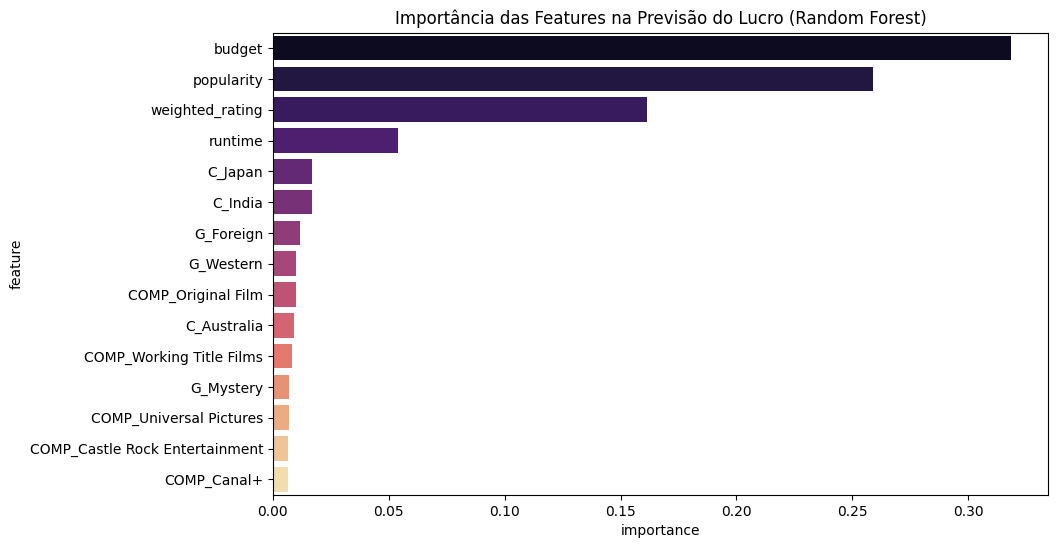

In [18]:
# Feature Importance
feature_importances = best_rf['regressor'].feature_importances_
feature_names = X.columns.tolist()

df_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
df_importances = df_importances.sort_values(by='importance', ascending=False).head(15)

# Gráfico de Importância
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=df_importances, palette='magma')
plt.title('Importância das Features na Previsão do Lucro (Random Forest)')
plt.show()



### 6.2. Conclusão e Implicações

#### Interpretação
A análise dos modelos revela um progresso claro na capacidade preditiva conforme algoritmos mais sofisticados são empregados. O XGBoost se destaca como o melhor desempenho geral, alcançando um R² próximo de 0.62 e apresentando o menor RMSE entre os modelos testados, o que indica sua superioridade na captura de relações complexas nos dados. A importância das variáveis mostra que a previsão de lucro é fortemente guiada por budget, popularity e weighted_rating, que concentram grande parte da explicação do modelo. Esses resultados sugerem que filmes com maior investimento, mais visibilidade prévia e avaliações ponderadas mais altas têm maior probabilidade de gerar lucros expressivos. A otimização do Random Forest também trouxe avanços pontuais, mantendo o R² próximo de 0.60 e estabilizando as métricas de erro, embora sem ganhos substanciais em relação ao modelo original.

#### Implicações
Os achados apontam que os fatores mais determinantes para o desempenho financeiro de um filme são relativamente mensuráveis e podem ser monitorados ainda na fase de pré-lançamento. Isso reforça o potencial desses modelos para apoiar decisões estratégicas no planejamento de produções, como análise de risco, estimativas de retorno e comparações entre projetos. O fato de budget, popularity e weighted_rating terem tanta relevância sugere que investimentos bem direcionados e campanhas que aumentem a visibilidade prévia podem ter impacto direto no lucro final. Além disso, o bom desempenho do XGBoost e o comportamento consistente do Random Forest otimizado indicam que técnicas baseadas em árvores são adequadas para este tipo de problema, podendo servir como base para modelos mais elaborados ou pipelines preditivos reais no mercado cinematográfico.

#### Limitações
Apesar dos resultados positivos, o desempenho geral dos modelos permanece moderado, com o melhor R² ao redor de 0.62 e erros médios ainda elevados — valores que mostram que uma parcela significativa da variabilidade do lucro permanece sem explicação. Isso acontece porque o lucro de filmes depende fortemente de elementos que não estão presentes no dataset, como estratégias de marketing, concorrência no calendário de lançamento, fenômenos culturais, força de franquias, recepção da crítica especializada, condições econômicas e até eventos imprevisíveis. A ausência dessas dimensões limita o teto de desempenho do modelo, independentemente do algoritmo utilizado. Além disso, muitos fatores possuem natureza qualitativa ou contextual, sendo difíceis de representar apenas com variáveis numéricas e binárias. Por fim, os ganhos limitados obtidos com a otimização do Random Forest indicam que ajustes de hiperparâmetros sozinhos não são suficientes; melhorias mais expressivas exigiriam expansão e enriquecimento do conjunto de features.